In [30]:
# Uses Co-integration 

import pandas as pd 
import numpy as np 
import statsmodels 
import statsmodels.api as sm 
from statsmodels.tsa.stattools import coint
from statsmodels.formula.api import ols
import yfinance as yf
import seaborn

# just set the seed for a random number generator
np.random.seed(107)

import matplotlib.pyplot as plt 


<H2><B>These are two fake securities:<B></H2> 
We model x's daily returns by drawing from a normal distrubtion. Then we perform a cumulative sum to get the value of X on each day

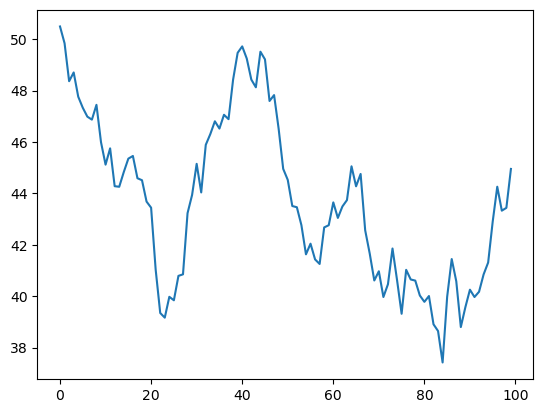

In [3]:
X_returns = np.random.normal(0,1,100) # generate the daily returns 
# sum them and shif all the prices up into a reasonable range 
X = pd.Series(np.cumsum(X_returns), name = "X") + 50
X.plot();


Now we generate Y. Remember that Y is supposed to have a deep economic link to X, so the price of Y should vary pretty similarly . We model this by taking X, shifting it up and adding some random noise drawn from a normal distribution 

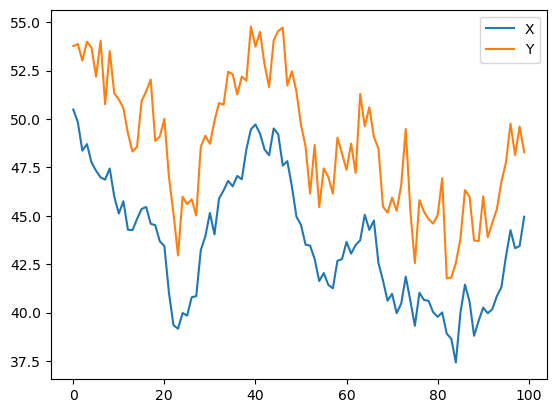

In [6]:
some_noise = np.random.normal(0,1,100)
Y = X + 5 + some_noise 
Y.name = "Y"
pd.concat([X,Y], axis = 1).plot();

<H2><B>DEF: Cointegratiom </B></H2>
We've constructed an example of two cointegrated series. Cointegrartion is a "different" for mof correlation (very loosely speaking) if two timer series are conintegrated, there is some linear combination betwenn them that will vary around a mean. At all points in time, the combination between them is related to the same probability distribution



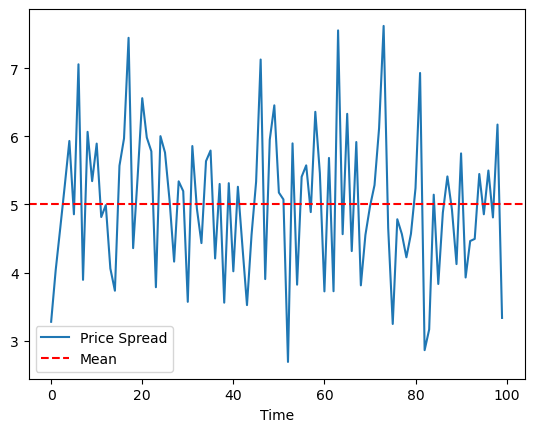

In [9]:
(Y-X).plot() # plot the spread 
plt.axhline((Y-X).mean(), color = 'red', linestyle = "--") # add the mean 
plt.xlabel("Time")
plt.legend(["Price Spread", "Mean"]);

<H2><B>Testing for Cointegration</B></H2>

Thats an intutative definition, but how do we test for this statistically? Ther is a covientient test that lives in statsmodels.tsa.stattools .
We should see avery low-pvalue, as we artifically created two series that are as cointegrated possible

In [19]:
#compute the p-value of the cointegration test
# will inform us as to whether the spread between the 2 timeseries is stationary 
# around its means 

score, pvalue, _ = coint(X,Y)
if pvalue < 0.05: #? This is important for statisctics to show the number must reach over a certain threshold 
    print(f"{pvalue} | Likey Cointegrated")  
else:
    print(print(f"{pvalue}  | Not Likely Cointegrated")  )

1.3819784036048863e-17 | Likey Cointegrated


<H2><B>Correlation vs. Cointegration</B></H2>
Correlation and cointegrationm while theoretically similar are not the same. To demonstrate this, we'll show examples of series that are correlated and no cointegrated, and vice versa. To start let's check the correlation of the series we just generated.


In [13]:
X.corr(Y)

0.9506148693582395

That's very high, as we would expect. But how would two series that are correlated but not cointegrated look? 

<H2><B>Correlation Without Cointegration</B></H2>
A simple example is two series that just diverge


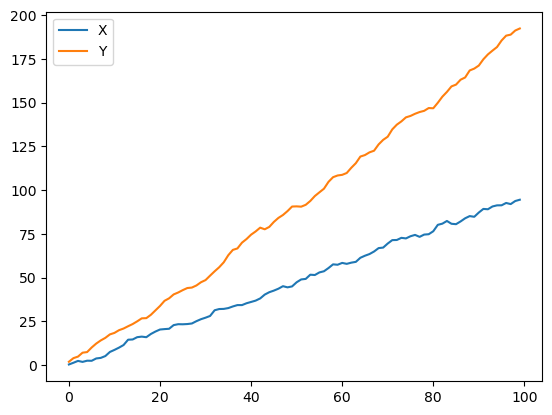

In [22]:
X_returns = np.random.normal(1,1,100)
Y_returns = np.random.normal(2,1,100)

X_diverging = pd.Series(np.cumsum(X_returns), name = 'X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name = 'Y')

pd.concat([X_diverging,Y_diverging],axis = 1).plot();

In [25]:
print("Correlation:" + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print("Cointegration test pvalue: " + str(pvalue))

Correlation:0.997652782191895
Cointegration test pvalue: 0.25172918907498704



<H2><B>   </B></H2>
<H2><B>   </B></H2>
<H2><B>   </B></H2>
<H2><B>   </B></H2>

<H2><B>WARNING: This will incur a large amount of multiple comparisons bias</B></H2>
For those not familiar with comparisons biass, it is the increaed chance to incorrectly generate a significant p-value when 
many test are run. If 100 tests are run on random data, we should expect to see 5 p-values below 0.05 on expectation. Because we will perform
<h4><i>N(N-1)/2</i></h4> comparisons, we should expect to see many incorrectly siginficant p-values. For the sake of example we will ignore this 
and continue. In Practice a a second verfication step would be needed if looking for pairs this way. Another approach is to pick a small number of pairs you have reasons to suspect might be cointegrated and test each individually. This will result in less exposure to multiple comparisons bias.

In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n,n))
    pvalue_matrix = np.ones((n,n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score 
            pvalue_matrix[i,j] = pvalue
            if pvalue <0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs 

<H2><B>  Looking for Cointegrated Pairs of Alternative Energy Securities </B></H2>
im looking through a set of solar company stocks to see if any of them are cointegrate. We'll be defining the list of securites we want to look through 
Then we'll get thr pricing data for the year of 2014.

In [7]:
symbol_list = ["GE","XOM","CVX","DQ","FSLR","SPY"]

prices_df = yf.download(symbol_list, start = "2014-01-01", end = "2015-01-01")["Close"]

prices_df_columns = map(lambda x: x.symbol, prices_df.columns)

[*********************100%***********************]  6 of 6 completed


[('GE', 'XOM')]


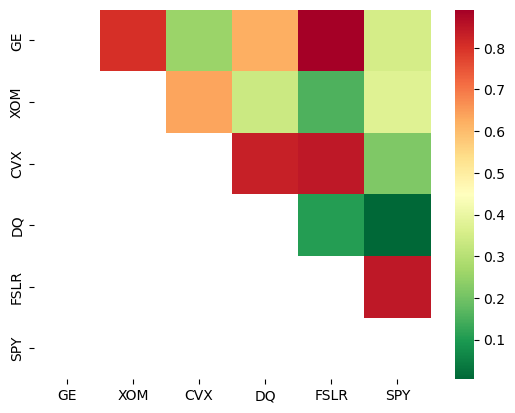

In [10]:
# now we will run this to see if the stocks are cointegrated 

scores, pvalues, pairs = find_cointegrated_pairs(prices_df)
seaborn.heatmap(pvalues, xticklabels= symbol_list, yticklabels= symbol_list, cmap = "RdYlGn_r"
                ,mask = (pvalues >= 0.95)
                )
print(pairs)

In [11]:
S1 = prices_df["GE"]
S2 = prices_df["XOM"]

In [14]:
score, pvalue, _ = coint(S1,S2)
print(f"pvalue {pvalue}")

pvalue 0.00474158927575945


beta : 0.6626679615221495


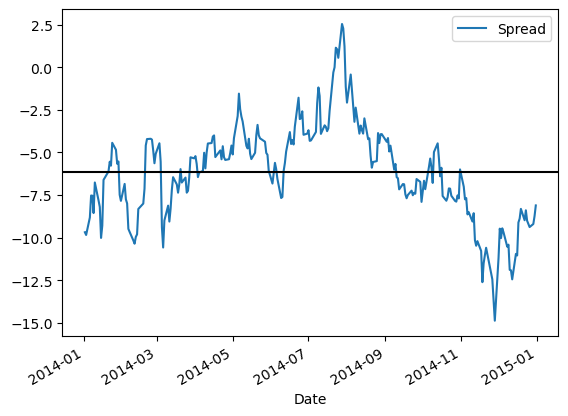

In [19]:
# We'll plot the spread of the two series. Here we use linear regression to calculate a coefficent for their linear combination.

S1 = sm.add_constant(S1)
results = sm.OLS(S2,S1).fit()
S1 = S1["GE"]
b = results.params["GE"]

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color = "black")
plt.legend(["Spread"])
print(f"beta : {b}")

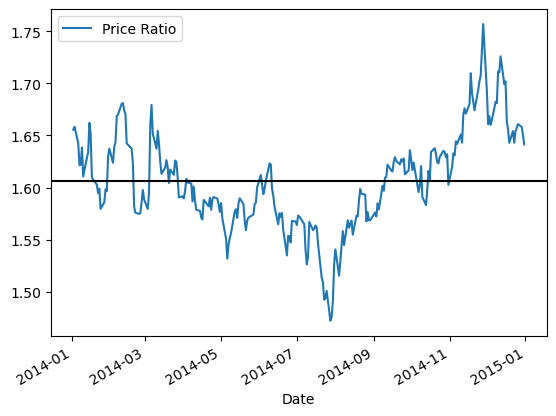

In [20]:
ratio = S1/S2
ratio.plot()
plt.axhline(ratio.mean(), color = "black")
plt.legend(["Price Ratio"])


In [21]:
def Z_score(series):
    return (series - series.mean()) / np.std(series)   

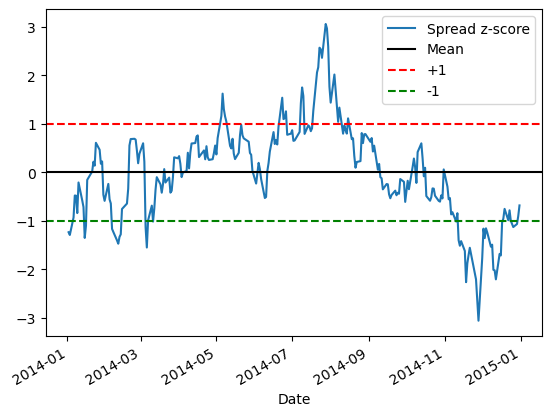

In [22]:
Z_score(spread).plot()
plt.axhline(Z_score(spread).mean(), color = "black")
plt.axhline(1.0, color = "red", linestyle = "--")
plt.axhline(-1.0, color = "green", linestyle = "--")
plt.legend(["Spread z-score", "Mean", "+1", "-1"]);

<H2> Simple Strategy</H2>
<ul>- Go "long" the spread whenever the z-score is below -1.0</ul>
<ul>- Go "short" the spread whenever the z-score is above 1.0</ul>
<ul>- Exit postions when the z-score is approaching 0</ul>

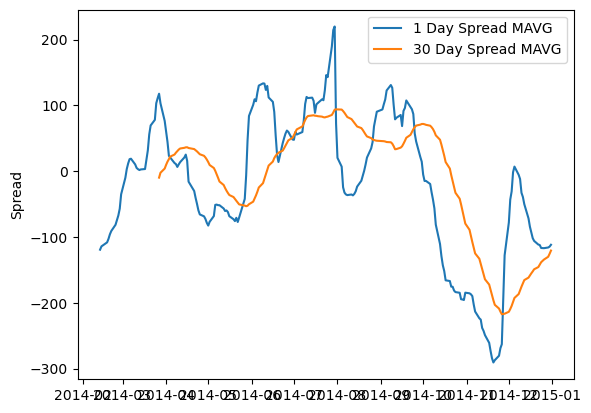

In [37]:
# Calculate rolling beta using a lambda function
rolling_beta = lambda y, x, window: pd.Series(
    [
        sm.OLS(
            y[i : i + window],
            sm.add_constant(x[i : i + window]),
        ).fit().params[1]
        for i in range(len(y) - window + 1)
    ],
    index=y.index[window - 1:],
)

# Calculate the rolling beta with a window of 30
beta_values = rolling_beta(S1, S2, 30)

spread = S2.iloc[29:] - beta_values.values * S1.iloc[29:]
spread.name = "spread"

# Get the 1 day moving average
spread_mavg1 = spread.rolling(window=1).mean()
spread_mavg1.name = "spread 1d mavg"

# Get the 30 day moving average
spread_mavg30 = spread.rolling(window=30).mean()
spread_mavg30.name = "spread 30d mavg"

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(["1 Day Spread MAVG", "30 Day Spread MAVG"])
plt.ylabel("Spread")
plt.show()


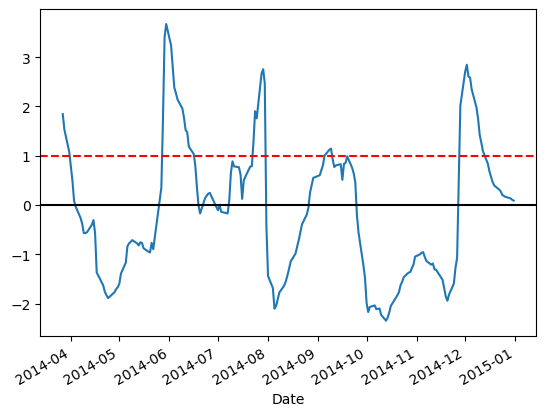

In [48]:
# take a rolling 30 day standard deviation
std_30 = spread.rolling(window = 30).std()
std_30.name = "std 30d"


#Compute the Z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.name = "z-score"
zscore_30_1.plot()
plt.axhline(0, color = "black")
plt.axhline(1.0, color = "red", linestyle = "--");

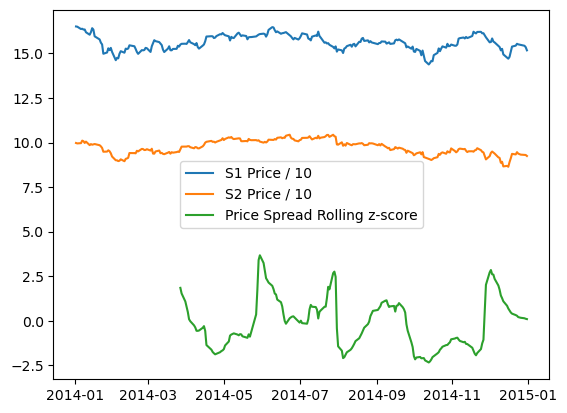

In [52]:
plt.plot(S1.index, S1.values/10)
plt.plot(S2.index, S2.values/10)
plt.plot(zscore_30_1.index, zscore_30_1.values)
plt.legend(["S1 Price / 10", "S2 Price / 10", "Price Spread Rolling z-score"]);